![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [112]:
import warnings
warnings.filterwarnings('ignore')

In [113]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [114]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [115]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [116]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [117]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

<AxesSubplot:title={'center':'Sentiminetos por aerolínea'}, xlabel='airline'>

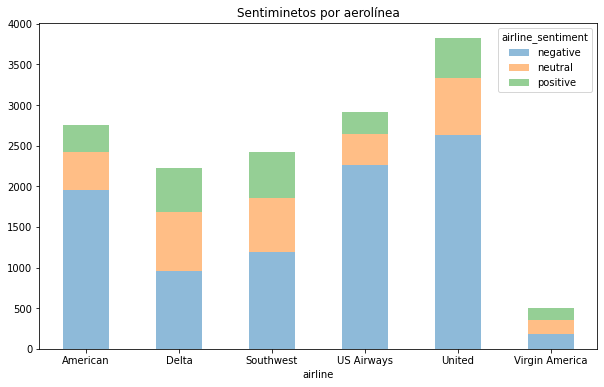

In [118]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

### Liberias y Variables de interés y predicción

In [119]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cohubay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\cohubay\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [120]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [121]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [122]:
# Celda 1
vect_A = CountVectorizer()
X_train_vect = vect_A.fit_transform(X_train)
X_test_vect = vect_A.transform(X_test)

In [123]:
ADA = ADASYN(random_state=0)
X_train_vect_res , y_train_res = ADA.fit_resample(X_train_vect,y_train)

In [124]:
clf = RandomForestClassifier(n_jobs=-1)

In [125]:
clf.fit(X_train_vect_res, y_train_res)

RandomForestClassifier(n_jobs=-1)

In [126]:
y_pred = clf.predict(X_test_vect)

In [127]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.83      0.89      0.86      3085
           0       0.58      0.49      0.54       984
           1       0.65      0.57      0.61       763

    accuracy                           0.76      4832
   macro avg       0.69      0.65      0.67      4832
weighted avg       0.75      0.76      0.75      4832



### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [128]:
# Celda 2
vect_no_stopw = CountVectorizer(stop_words='english')
X_train_vect_nsw = vect_no_stopw.fit_transform(X_train)
X_test_vect_nsw = vect_no_stopw.transform(X_test)

In [129]:
ADA = ADASYN(random_state=0)
X_train_vect_nsw_res , y_train_res = ADA.fit_resample(X_train_vect_nsw, y_train)

In [130]:
clf = RandomForestClassifier(n_jobs=-1)

In [131]:
clf.fit(X_train_vect_nsw_res, y_train_res)

RandomForestClassifier(n_jobs=-1)

In [132]:
y_pred = clf.predict(X_test_vect_nsw)

In [133]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.86      0.79      0.82      3085
           0       0.48      0.55      0.51       984
           1       0.56      0.66      0.60       763

    accuracy                           0.72      4832
   macro avg       0.63      0.66      0.65      4832
weighted avg       0.74      0.72      0.73      4832



### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [134]:
# Celda 3
def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word) for word in words]

In [135]:
vect = CountVectorizer()
vect.fit_transform(X_train)

<9808x12056 sparse matrix of type '<class 'numpy.int64'>'
	with 156290 stored elements in Compressed Sparse Row format>

In [136]:
# Obtención e impresión de los lemas de cada palabra de la lista asumiendo que cada palabra es un sustantivo
words = list(vect.vocabulary_.keys())
[wordnet_lemmatizer.lemmatize(word) for word in words]
[wordnet_lemmatizer.lemmatize(word,pos='v') for word in words]

['jetblue',
 'of',
 'course',
 'be',
 'americanair',
 'complt',
 'incompetence',
 'on',
 'flt',
 '295',
 'lav',
 'delay',
 'from',
 'pln',
 'that',
 'lnded',
 'last',
 'nite',
 'no',
 'internet',
 'and',
 'poor',
 'svc',
 'not',
 'what',
 'expect',
 'southwestair',
 'flight',
 '4968',
 'n8325d',
 'depart',
 'mco',
 'enroute',
 'to',
 'no_airport',
 'http',
 'co',
 'fd4snvkiem',
 'usairways',
 'do',
 'anyone',
 'your',
 'airline',
 'know',
 'how',
 'do',
 'their',
 'job',
 'unite',
 'want',
 'plane',
 'dad',
 'my',
 '386',
 'dallas',
 'jacksonville',
 'fl',
 'have',
 'be',
 'cancel',
 'flightled',
 'one',
 'notify',
 'me',
 'go',
 'it',
 'be',
 'try',
 'make',
 'but',
 'probably',
 'too',
 'late',
 'do',
 'see',
 'an',
 'email',
 'could',
 'call',
 'pittsburgh',
 'international',
 'always',
 'look',
 'forward',
 'jb',
 'rt',
 'bostongarden',
 'look',
 'welcome',
 'you',
 'onboard',
 'have',
 'the',
 'ability',
 'switch',
 'cannot',
 'tell',
 'where',
 'bag',
 'be',
 'refuse',
 'board',


In [137]:
vect_lemas = CountVectorizer(analyzer=split_into_lemmas)

In [138]:
X_train_vect_lemas = vect_lemas.fit_transform(X_train)
X_test_vect_lemas = vect_lemas.transform(X_test)

In [139]:
ADA = ADASYN(random_state=0)
X_train_vect_lemas_res , y_train_res = ADA.fit_resample(X_train_vect_lemas, y_train)

In [140]:
clf = RandomForestClassifier(n_jobs=-1)

In [142]:
clf.fit(X_train_vect_lemas_res, y_train_res)

RandomForestClassifier(n_jobs=-1)

In [143]:
y_pred = clf.predict(X_test_vect_lemas)

In [144]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.82      0.88      0.85      3085
           0       0.57      0.48      0.52       984
           1       0.60      0.53      0.57       763

    accuracy                           0.75      4832
   macro avg       0.66      0.63      0.65      4832
weighted avg       0.74      0.75      0.74      4832



### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [145]:
# Celda 4
vect_lemas_nsw = CountVectorizer(analyzer=split_into_lemmas, stop_words='english')

In [146]:
X_train_vect_lemas_nsw = vect_lemas_nsw.fit_transform(X_train)
X_test_vect_lemas_nsw = vect_lemas_nsw.transform(X_test)

In [147]:
ADA = ADASYN(random_state=0)
X_train_vect_lemas_nsw_res , y_train_res = ADA.fit_resample(X_train_vect_lemas_nsw, y_train)

In [148]:
clf = RandomForestClassifier(n_jobs=-1)

In [149]:
clf.fit(X_train_vect_lemas_nsw_res, y_train_res)

RandomForestClassifier(n_jobs=-1)

In [151]:
y_pred = clf.predict(X_test_vect_lemas_nsw)

In [152]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.83      0.88      0.85      3085
           0       0.57      0.50      0.53       984
           1       0.61      0.53      0.57       763

    accuracy                           0.75      4832
   macro avg       0.67      0.64      0.65      4832
weighted avg       0.74      0.75      0.74      4832



### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

El modelo con mejor desempeño fue el que solamente se utilizo **CountVectorizer** sin ningun parámetro con **f1-Score** de **0.86**, **0.54** y **0.61** para cada una de las clases respectivamente. Por otra parte el modelo con peor desempeño fue el que utilizo el parámetro de **Stopwords** con un **f1-Score** de **0.82**, **0.51** y **0.60** para cada una de las clases respectivamente. Sí analizaramos solamente la metrica de **accuracy** encontrariamos las mismas conclusiones anteriormente expuestas sobre el desempeño de los modelos.

Por otra parte consideramos que el desempeño del mejor modelo esta relacionado con la longuitud de texto dado que en texto tan cortos, el eliminar **StopWords** puede afectar el contexto de la idea, lo que se ve reflejado en las métricas de desempeño.. 

